In [40]:
import numpy as np
import pandas as pd

from dotenv import load_dotenv
import os

import unicodedata
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score, fbeta_score, roc_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import logging
import json
import re
import string 
import joblib
import warnings
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from mlflow.models.signature import infer_signature

warnings.filterwarnings("ignore")

In [2]:
load_dotenv()
ruta_cst_sample = os.getenv("customer_support_twitter_sample")
ruta_cst_twcs = os.getenv("customer_support_twitter_twcs")

ruta_gpsa = os.getenv("google_play_store_apps")
ruta_gpsa_user_r = os.getenv("google_play_store_apps_user_reviews")

ruta_ncd = os.getenv("news_category_dataset")

ruta_yadb = os.getenv("yelp_academic_dataset_business")
ruta_yadc = os.getenv("yelp_academic_dataset_checkin")
ruta_yadr = os.getenv("yelp_academic_dataset_review")
ruta_yadt = os.getenv("yelp_academic_dataset_tip")
ruta_yadu = os.getenv("yelp_academic_dataset_user")

In [3]:
sample_cst = pd.read_csv(ruta_cst_sample)
sample_cst.shape

(93, 7)

In [4]:
sample_cst.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0


In [3]:
data_cst_twcs = pd.read_csv(ruta_cst_twcs)
data_cst_twcs.shape

(2811774, 7)

In [4]:
data_cst_twcs.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [6]:
data_gpsa = pd.read_csv(ruta_gpsa)
data_gpsa.shape

(10841, 13)

In [7]:
data_gpsa_user_r = pd.read_csv(ruta_gpsa_user_r)
data_gpsa_user_r.shape

(64295, 5)

In [8]:
data_gpsa_user_r.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [9]:
data_ncd = pd.read_json(ruta_ncd, lines=True)
data_ncd.shape

(209527, 6)

In [10]:
data_ncd.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [11]:
data_yadb = pd.read_json(ruta_yadb, lines=True)
data_yadb.shape

(150346, 14)

In [12]:
data_yadb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [13]:
data_yadc = pd.read_json(ruta_yadc, lines=True)
data_yadc.shape

(131930, 2)

In [14]:
data_yadc.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


In [ ]:
data_yadr = pd.read_json(ruta_yadr, lines=True)
data_yadr.shape

In [ ]:
data_yadr.head()

In [3]:
data_yadt = pd.read_json(ruta_yadt, lines=True)
data_yadt.shape

(908915, 5)

In [4]:
data_yadt.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [ ]:
data_yadu = pd.read_json(ruta_yadu, lines=True)
data_yadu.shape

In [ ]:
data_yadu.head()

In [6]:
data_cst_twcs.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [5]:
data_cst_twcs.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')

In [11]:
data_cst_twcs['inbound'].dtypes

dtype('bool')

In [10]:
data_cst_twcs['inbound'].value_counts(dropna=False)

inbound
True     1537843
False    1273931
Name: count, dtype: int64

In [9]:
print('Shape: ', data_cst_twcs.shape)
print('ID tweet Numeros Unicos: ', data_cst_twcs['tweet_id'].nunique())
print('ID author Numeros Unicos: ', data_cst_twcs['author_id'].nunique())
print('ID response tweet Numeros Unicos: ', data_cst_twcs['response_tweet_id'].nunique())
print('ID response in tweet Numeros Unicos: ', data_cst_twcs['in_response_to_tweet_id'].nunique())

Shape:  (2811774, 7)
ID tweet Numeros Unicos:  2811774
ID author Numeros Unicos:  702777
ID response tweet Numeros Unicos:  1771145
ID response in tweet Numeros Unicos:  1774822


In [5]:
data_cst_twcs['inbound'] = data_cst_twcs['inbound'].astype('int')

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alejo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
english_stopwords = stopwords.words('english')

In [20]:
# Preprocesamiento de texto
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text, language='english')
    filtered_text = ' '.join([word for word in tokens if word not in stop_words])
    return filtered_text

def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar tildes
    text = ''.join(
        c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'
    )
    # Eliminar signos de puntuación y caracteres especiales
    text = re.sub(r'[^a-zñü\s]', '', text)
    # Tokenización básica
    tokens = text.split()
    return tokens

In [21]:
data_cst_twcs["text_clean"] = data_cst_twcs["text"].apply(preprocess_text)
data_cst_twcs["text_clean"].head()

0    [i, understand, i, would, like, to, assist, yo...
1    [sprintcare, and, how, do, you, propose, we, d...
2    [sprintcare, i, have, sent, several, private, ...
3    [please, send, us, a, private, message, so, th...
4                                 [sprintcare, i, did]
Name: text_clean, dtype: object

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_cst_twcs['text'], data_cst_twcs['inbound'], test_size=0.2, stratify=data_cst_twcs['inbound'], random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)
print('X_train: ', X_train.shape)
print('X_valid: ', X_valid.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_valid: ', y_valid.shape)
print('y_test: ', y_test.shape)

X_train:  (1574593,)
X_valid:  (674826,)
X_test:  (562355,)
y_train:  (1574593,)
y_valid:  (674826,)
y_test:  (562355,)


In [9]:
# Vectorizar el texto con TF-IDF
vectorizer = TfidfVectorizer(stop_words=english_stopwords, max_features=100, lowercase=True, token_pattern=r'\b\w+\b')

X_train = vectorizer.fit_transform(X_train)
y_train = y_train

In [51]:
print(type(X_train))
print(type(y_train))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'pandas.core.series.Series'>


In [52]:
print(X_test.dtypes)

object


In [10]:
X_test = vectorizer.transform(X_test)
X_valid = vectorizer.transform(X_valid)

In [11]:
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

0:	learn: 0.6313015	total: 462ms	remaining: 3m 50s
100:	learn: 0.3638038	total: 22.4s	remaining: 1m 28s
200:	learn: 0.3454089	total: 40.3s	remaining: 60s
300:	learn: 0.3375362	total: 1m	remaining: 39.7s
400:	learn: 0.3331273	total: 1m 24s	remaining: 20.9s
499:	learn: 0.3300415	total: 1m 42s	remaining: 0us


In [12]:
model.predict(X_test)

array([1, 1, 0, ..., 1, 1, 0], shape=(562355,))

In [13]:
# Generar predicciones de probabilidad
y_probs = model.predict_proba(X_test)[:, 1]  # Si es un clasificador binario
y_probs

array([0.71495755, 0.99637055, 0.05797275, ..., 0.78029494, 0.78876258,
       0.03460762], shape=(562355,))

In [14]:
# Definir los thresholds a probar
thresholds = np.arange(0.0, 1.01, 0.01)

# Crear arrays para almacenar las métricas
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []
roc_auc_scores = []
roc_pr_auc_score = []
lift_scores = []

# Tasa global de positivos (P(Y=1))
global_rate = np.mean(y_test)

# Evaluar las métricas para cada threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_probs))  # Se usa y_probs para ROC
    roc_pr_auc_score.append(average_precision_score(y_test, y_probs))  # Se usa y_probs

In [15]:
# Encontrar el mejor threshold según una métrica, por ejemplo, F1-score
best_threshold_index = np.argmax(f1_scores) #50 #37
best_threshold = thresholds[best_threshold_index]

print(f"Mejor threshold: {best_threshold}")
print(f"Precision: {precision_scores[best_threshold_index]}")
print(f"Recall: {recall_scores[best_threshold_index]}")
print(f"F1-score: {f1_scores[best_threshold_index]}")
print(f"Accuracy: {accuracy_scores[best_threshold_index]}")
print(f"ROC AUC: {roc_auc_scores[best_threshold_index]}")
print(f"ROC PR AUC: {roc_pr_auc_score[best_threshold_index]}")

Mejor threshold: 0.45
Precision: 0.8193782566760075
Recall: 0.9335726292311644
F1-score: 0.8727558992892129
Accuracy: 0.8511136203999253
ROC AUC: 0.9237128752847031
ROC PR AUC: 0.9292354639955308


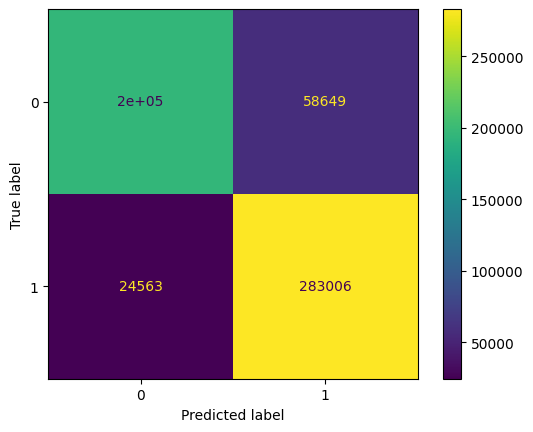

          Predicted 0  Predicted 1
Actual 0       196137        58649
Actual 1        24563       283006


In [16]:
y_pred = model.predict(X_test).astype(int)
predictions = [round(value) for value in y_pred]

cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

# Crea un DataFrame a partir de la matriz de confusión
cm_table = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Muestra la matriz en forma de tabla
print(cm_table)

In [17]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.20%


In [18]:
presicion = precision_score(y_test, predictions)
print("Precision: %.2f%%" % (presicion * 100.0))

Precision: 82.83%


In [19]:
recall = recall_score(y_test, predictions)

#print("Recall: ", recall)
print("Recall: %.2f%%" % (recall * 100.0))

Recall: 92.01%


In [20]:
f1 = f1_score(y_test, predictions)

#print("F1-Score: ", f1)
print("F1-Score: %.2f%%" % (f1 * 100.0))

F1-Score: 87.18%


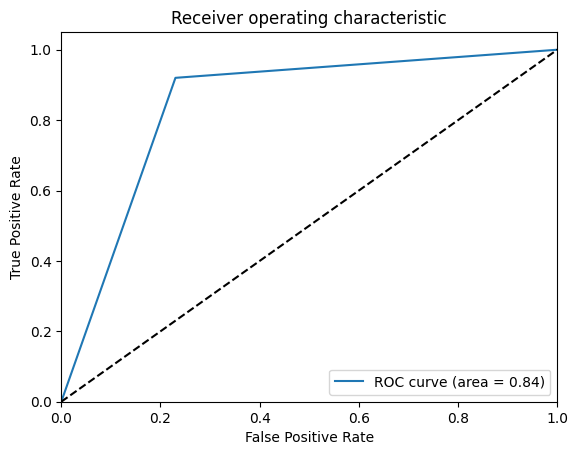

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, predictions) #precision_recall_curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

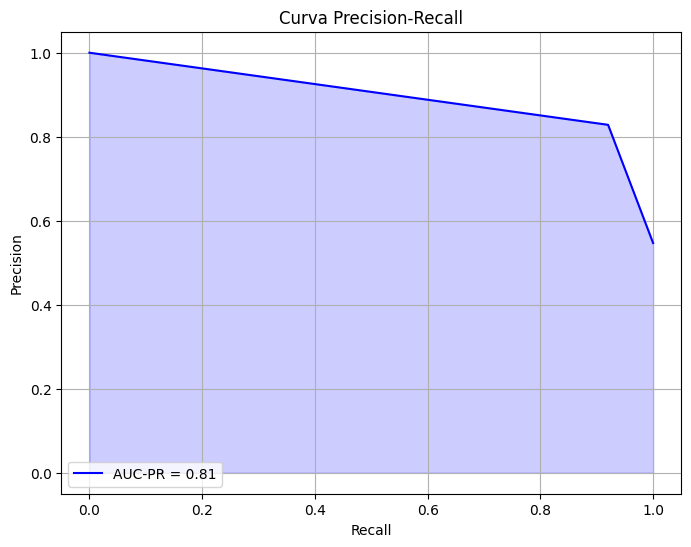

In [22]:
# 1. Obtener Precision, Recall y Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

# 2. Calcular el AUC-PR
auc_pr = average_precision_score(y_test, predictions)

# 3. Graficar la Curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'AUC-PR = {auc_pr:.2f}')
plt.fill_between(recall, precision, alpha=0.2, color='b')

# 4. Configurar el gráfico
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
# Graficar las métricas
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='o')
plt.plot(thresholds, roc_auc_scores, label='ROC AUC', marker='o')
plt.plot(thresholds, roc_pr_auc_score, label='ROC PR AUC', marker='o')


# Añadir etiquetas y leyenda
plt.xlabel('Threshold')
plt.ylabel('Metric Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
#mlflow.create_experiment("experimento_prueba")

In [37]:
try:
    mlflow.create_experiment("experimento_prueba")
    print("Experimento creado")
except:
    mlflow.set_experiment("experimento_prueba")
    print("Experimento ya existe")


Experimento ya existe


In [25]:
X_train, X_test, y_train, y_test = train_test_split(data_cst_twcs['text'], data_cst_twcs['inbound'], test_size=0.2, stratify=data_cst_twcs['inbound'], random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

In [41]:
with mlflow.start_run():
    # Define y entrena el pipeline
    catboost_params = {
        "iterations": 500,
        "depth": 6,
        "learning_rate": 0.1,
        "verbose": 100
    }

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=english_stopwords, max_features=100, lowercase=True, token_pattern=r'\b\w+\b')),
        ('catboost', CatBoostClassifier(**catboost_params))
    ])
    pipeline.fit(X_train, y_train)

    # Inferir signature para input/output
    signature = infer_signature(X_train, y_train)

    # Registra el modelo con un ejemplo de entrada
    input_example = np.array(X_test[:1])  # Toma una muestra como ejemplo de entrada
    mlflow.sklearn.log_model(pipeline, "modelo_catboost", input_example=input_example, signature=signature, registered_model_name="modelo_catboost_prueba")

    # Registra las métricas
    accuracy = pipeline.score(X_test, y_test)
    mlflow.log_metric("accuracy", accuracy)

    # Registra los hiperparámetros del modelo
    mlflow.log_params(catboost_params)

    print(f"Modelo registrado con precisión: {accuracy}")

0:	learn: 0.6313015	total: 275ms	remaining: 2m 17s
100:	learn: 0.3638038	total: 18.4s	remaining: 1m 12s
200:	learn: 0.3454089	total: 36.5s	remaining: 54.3s
300:	learn: 0.3375362	total: 54.9s	remaining: 36.3s
400:	learn: 0.3331273	total: 1m 16s	remaining: 18.8s
499:	learn: 0.3300415	total: 1m 32s	remaining: 0us


Successfully registered model 'modelo_catboost_prueba'.
Created version '1' of model 'modelo_catboost_prueba'.


Modelo registrado con precisión: 0.8520294120262112


In [42]:
client = mlflow.tracking.MlflowClient()
models = client.search_registered_models()
for model in models:
    print(model.name)

modelo_catboost_prueba


In [48]:
with mlflow.start_run():
    # Define nuevo modelo
    new_catboost_params = {
        "iterations": 600,  # Cambios en hiperparámetros
        "depth": 8,
        "learning_rate": 0.05,
        "verbose": 100
    }

    new_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=english_stopwords, max_features=200, lowercase=True, token_pattern=r'\b\w+\b')),
        ('catboost', CatBoostClassifier(**new_catboost_params))
    ])
    new_pipeline.fit(X_valid, y_valid)

    # Inferir signature para input/output
    signature = infer_signature(X_valid, y_valid)

    # Registra el modelo con un ejemplo de entrada
    input_example = np.array(X_valid[:1])  # Toma una muestra como ejemplo de entrada

    # Registra el modelo en MLflow
    model_uri = "runs:/" + mlflow.active_run().info.run_id + "/modelo_catboost_prueba"
    mlflow.sklearn.log_model(new_pipeline, "modelo_catboost_prueba", input_example=input_example, signature=signature, registered_model_name="modelo_catboost_prueba_v2")

    # Registra los hiperparámetros y métricas
    accuracy = new_pipeline.score(X_valid, y_valid)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_params(new_catboost_params)

    # Registra el modelo en el Model Registry
    mlflow.register_model(model_uri=model_uri, name="modelo_catboost_prueba")

    print(f"Nuevo modelo registrado con precisión: {accuracy}")

0:	learn: 0.6575283	total: 228ms	remaining: 2m 16s
100:	learn: 0.3297735	total: 17.5s	remaining: 1m 26s
200:	learn: 0.2933245	total: 34.5s	remaining: 1m 8s
300:	learn: 0.2753872	total: 51.7s	remaining: 51.3s
400:	learn: 0.2633034	total: 1m 10s	remaining: 34.8s
500:	learn: 0.2555405	total: 1m 26s	remaining: 17.1s
599:	learn: 0.2497838	total: 1m 43s	remaining: 0us


Successfully registered model 'modelo_catboost_prueba_v2'.
Created version '1' of model 'modelo_catboost_prueba_v2'.


Nuevo modelo registrado con precisión: 0.8911956563617881


Registered model 'modelo_catboost_prueba' already exists. Creating a new version of this model...
Created version '3' of model 'modelo_catboost_prueba'.


In [49]:
for model in client.get_registered_model("modelo_catboost_prueba").latest_versions:
    print(f"Version: {model.version}, Stage: {model.current_stage}")

Version: 3, Stage: None


In [ ]:
client = mlflow.tracking.MlflowClient()
for model in client.get_registered_model("modelo_catboost_prueba").latest_versions:
    print(f"Versión: {model.version}, Etapa: {model.current_stage}, Accuracy: {model.metrics.get('accuracy')}")

AttributeError: 'ModelVersion' object has no attribute 'metrics'

: 

In [45]:
champion_model = mlflow.sklearn.load_model("models:/modelo_catboost_prueba/Production")
champion_model.predict(X_test)

MlflowException: No versions of model with name 'modelo_catboost_prueba' and stage 'Production' found

In [40]:
space = {
    'iterations': 500,
    'depth': hp.quniform('depth', 3, 10, 1),
    'learning_rate': hp.quniform('learning_rate', 0.1, 0.5, 0.1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'border_count': hp.quniform('border_count', 32, 255, 1),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 10, 0.1),
    'random_seed': 0
}

In [61]:
def objective(space):
    clf = CatBoostClassifier(
        iterations=int(space['iterations']),
        depth=int(space['depth']),
        learning_rate=space['learning_rate'],
        l2_leaf_reg=space['l2_leaf_reg'],
        border_count=int(space['border_count']),
        subsample=space['subsample'],
        scale_pos_weight=space['scale_pos_weight'],
        random_seed=int(space['random_seed']),
        verbose=False
    )

    # Conjunto de evaluación
    evaluation = [
        (X_train, y_train),
        (X_valid, y_valid)
    ]

    clf.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        early_stopping_rounds=10
    )

    # Predicción y evaluación
    pred = clf.predict(X_valid)
    F1_SCORE = f1_score(y_valid, pred)
    print("F1-score:", F1_SCORE)

    return {'loss': -F1_SCORE, 'status': STATUS_OK}  # Minimizar la pérdida

In [62]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

F1-score:                                             
0.8758195851102203                                    
 10%|█         | 1/10 [02:07<19:08, 127.64s/trial, best loss: -0.8758195851102203]

: 